In [3]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D,Conv2DTranspose
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import copy
import matplotlib.pyplot as plt
import cv2

import numpy as np

Room/Icon Recommendation:

##  Problem Desciption:
Given a segmentation with empty space, we are hoping a contextual-conditional GAN will help us identify what kind of room types/ icons can be put inside that area by using the contextual information of its surrounding icons.


In [7]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]


Text(0.5, 1.0, 'True Segmentation Map')

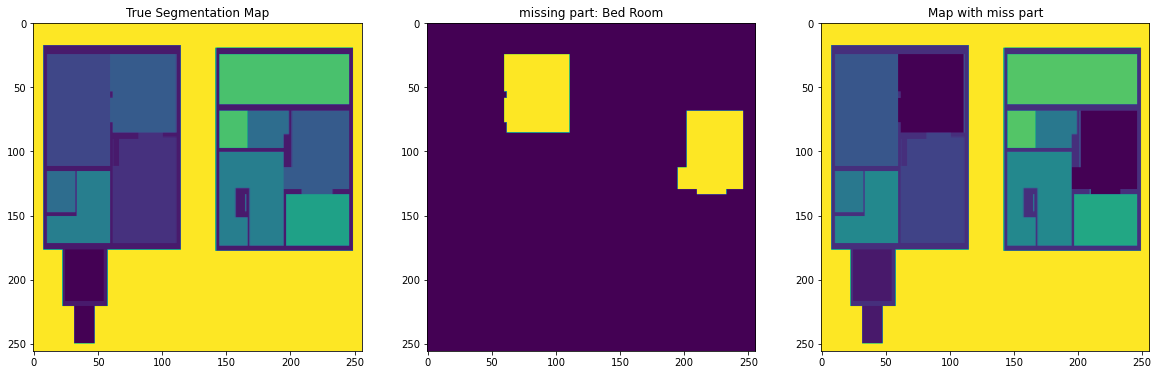

In [27]:
ex = 1200
index = 5
example = X_train[ex].reshape(256,256)
B = copy.copy(example)
ex_copy = copy.copy(example)
ex_copy[ex_copy!=index]=0

fig, axs = plt.subplots(1,3,figsize = (20,15))
'''
This is what we would like the GAN to produce
'''
axs[1].imshow(ex_copy)
axs[1].set_title("missing part: {}".format(room_classes[index]))

'''
This is what we input to the gan generator to generate something like the true img
'''
axs[2].imshow(B-ex_copy)
axs[2].set_title("Map with miss part" )
axs[0].imshow(B)
axs[0].set_title("True Segmentation Map")

The segmentation Map (as plotted above is a 2 dimensional array with label (1-11) for rooms and (1-12) for icons, backgrounds are changed to 15 to differentiate with missing part (which is labeled 0).

**True Segmentation Map**:
   The true segmentation map of 1 particular floor plan.
   
**Map with missing part**:
   The input that is fed in the GAN to generate context image with all other labels unchanged but with the target recommendation type (in this bedroom index 5) set to zeros (as indicated by the dark blue blocks in the plot.
   
**Missing part**:
   The true missing labels plot of the Map with missing part.

**Relationship**:
Missing part  + Map with missing part = True Segmentation Map


As this example shows, we attempt to infer the missing part (in this example Bedrooms) by using the network to infer the Map_with_missing_part images of our segmentation maps. 
    We developed context-conditional generative adversarial networks (CC-GANs) which are conditional GANs where the generator is trained to fill in a missing image patch and the generator and discriminator are conditioned on the surrounding pixels. In particular, the generator receives as input an image with a given feature( room type or icon) masked and then outputs an entire image. 



## Achitecture Description

**NOTE: This Context-Encoder Framework is built on the work done on  https://github.com/eriklindernoren/Keras-GAN/tree/master/context_encoder with different functions but same class structures. The reference paper is https://arxiv.org/abs/1611.06430**

The architecture of our generative model is consists of a sequence of convolutional layers with subsampling (but no pooling) followed by a sequence of fractionally-strided convolutional layers. The input is a bunch of segmentation maps as plotted above) with dimension. is (Num of image * 256 *256 *1)

The generator is an autoencoder that takes the image of a mask_with_missing part img and aims to re-fill the  missing part with the proper label (say 5 for room and 6 for bath room) with out put (256,256,1) or at least highlight the correct  difference

The discirminator takes either the true missing part or the fake version and output 0 or 1.

In generative model, each of the three convolutional layer(256,128,8) is followed by a Leaky rectified linear layer, followed by a spatial batch normalization in encoder, while in decoder, each upsampling and convolutional layer is followed by Leaky rectified linear layer and a spatial batch normalization in the end. The discriminator took the completed image as input with 3 convolutional layers each followed by Leaky rectified linear layer to give to binary output.



In [22]:
class ContextEncoder():
    
    def __init__(self,Training_set,Type):
       
        self.TRAIN = Training_set
        self.index = Type
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols,self.channels)
        
        #The missing shape will be the same as the input image
        #But only with the missing part of the picture non-zero
        self.missing_shape = (self.img_rows, self.img_cols,self.channels)
        
        
        # ---Build the generator----#
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        
        # ---Build the generator----#


        #-- Build and compile the discriminator---#
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer= Adam(0.0002, 0.5),
            metrics=['accuracy'])
        #-- Build and compile the discriminator-#

      
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # stacked generator and discriminator
        # Trains generator to fool discriminator
        self.GAN = Model(masked_img , [gen_missing, valid])
        self.GAN.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.995, 0.005],
            optimizer=Adam(0.0002, 0.5))

        
    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(256, kernel_size=3, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(128, kernel_size=3,strides = 2, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(8, kernel_size=3,strides=2,  padding="same"))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(128, kernel_size=1, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2DTranspose(256, kernel_size=3, activation ="relu", padding="same"))
        model.add(UpSampling2D())
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(self.channels, kernel_size=3, padding="same", activation ="tanh"))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)
    

    def build_discriminator(self):
        '''
        This function build a discriminatro that aims to identify real/fake image
        
        '''

        model = Sequential()
        model.add(Conv2D(512, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)
    
    #Masking specific type of icons/ rooms
    def mask_type(self,imgs):  
        '''
        #Index is for what part of the room you would like to mask


        This function takes input imgs and out put the masked_img (without certain icon)
        and the missing_icon itself
        '''
        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty_like(imgs)
        for i, img in enumerate(imgs):
            img = img.reshape(256,256)
            temp = img.copy()
            # Single out the missing icon
            temp[temp != self.index] = 0 
            temp_re = temp.reshape(256,256,1)

            missing_parts[i] = temp_re
            # Use initial img to generate the masked img
            masked_imgs[i] = (img- temp).reshape(256,256,1)

        return masked_imgs,missing_parts

    def train(self, epochs, batch_size=128, sample_interval=50):


        # Rescale -1 to 1
        X_train = self.TRAIN
        
        print("starting epoch...")
        for epoch in range(epochs):
            
            print("epoch {}".format(epoch))

            # ---------------------
            #  Train Discriminator
            # Select a random batch of images
            imgs = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
            
            
            #Single Out the masked image
            masked_imgs, missing_parts = self.mask_type(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)
            
            
            # Train the discriminator on true missing images
            d_loss_real = self.discriminator.train_on_batch(missing_parts,  np.ones((batch_size, 1)))
            
            #Train the discriminator on fake image
            d_loss_fake = self.discriminator.train_on_batch(gen_missing,np.zeros((batch_size, 1)))
            d_loss = 0.8 * np.add(d_loss_real, d_loss_fake)
            
            
            #----Training Generator----#
            g_loss = self.GAN.train_on_batch(masked_imgs, [missing_parts, np.ones((batch_size, 1))])

            # Plot the progress
            print ("%d , Discriminator loss: %f ,Generator loss: %f, mse: %f" % (epoch, d_loss[0], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                #Print a random figure to see how process goes
                idx = np.random.randint(0, X_train.shape[0], 1)
                print("index",idx)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
                

    def sample_images(self, epoch, imgs):
        
        #plot img and save
        masked_imgs,miss_part= self.mask_type(imgs)

        gen_missing = self.generator.predict(masked_imgs)
        
        fig, axs = plt.subplots(1,5,figsize = (20,15))

        
        IMG = imgs[0].reshape(256,256)
        GEN = gen_missing[0].reshape(256,256)

        
        axs[0].imshow(IMG)
        axs[0].set_title("True Img")
        
        axs[3].imshow(GEN)
        axs[3].set_title("Predicted")
        
        axs[2].imshow( miss_part[0].reshape(256,256))
        axs[2].set_title("True Missing part" + room_classes[self.index])
        
        axs[1].imshow( masked_imgs[0].reshape(256,256) )
        axs[1].set_title("Masked Img: without " + room_classes[self.index])
        
        fig.savefig("progress/%d.png" % epoch)

In [28]:
MOD= ContextEncoder(X_train,5)  #Five is room 

new
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 256, 256, 256)     2560      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 128)     295040    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 8)         9224      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 64, 64, 8)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 8)    

Progress Epoch Screen Shots:
    

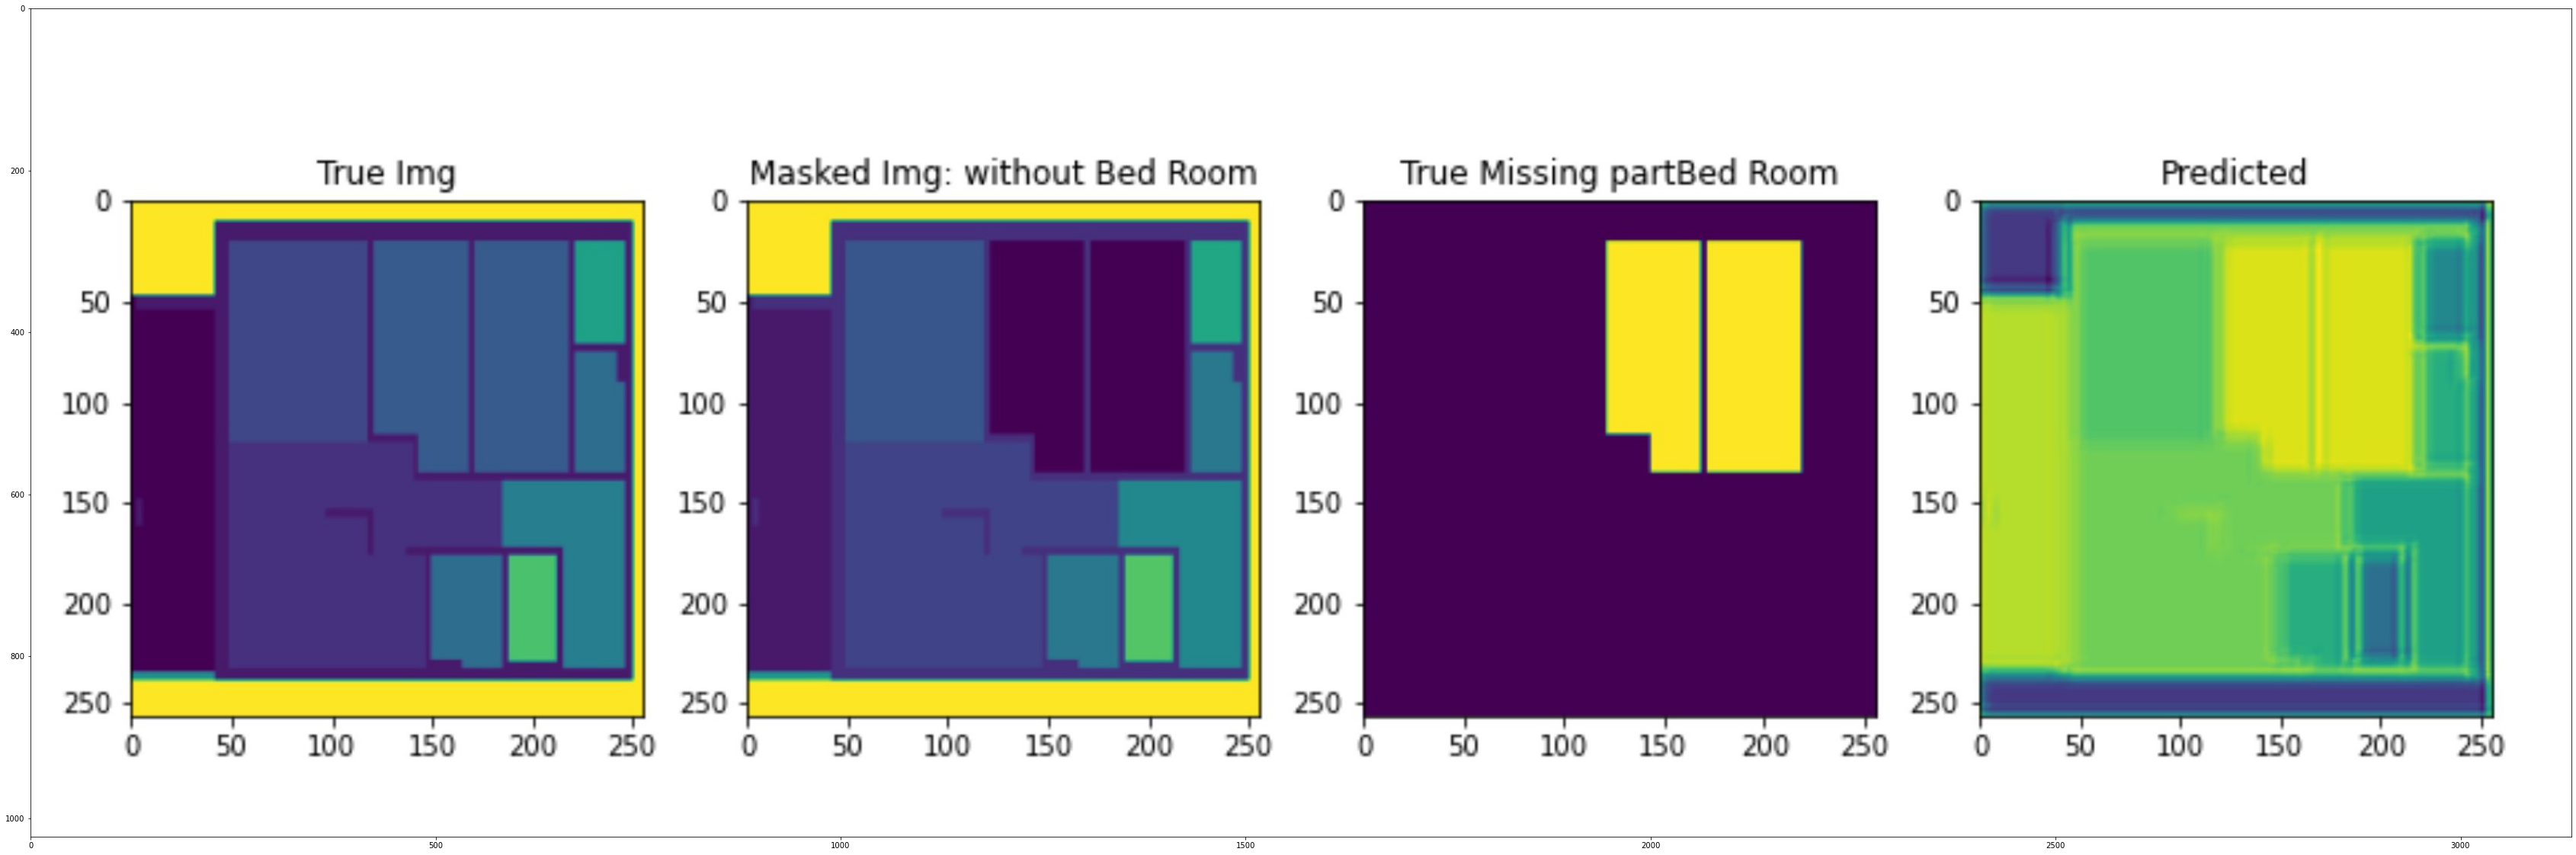

In [50]:
import matplotlib.image as mpimg
image = mpimg.imread("progress/epoch.jpg")
image1 = mpimg.imread("progress/14.png")
plt.figure(figsize = (100,20))
plt.imshow(image)

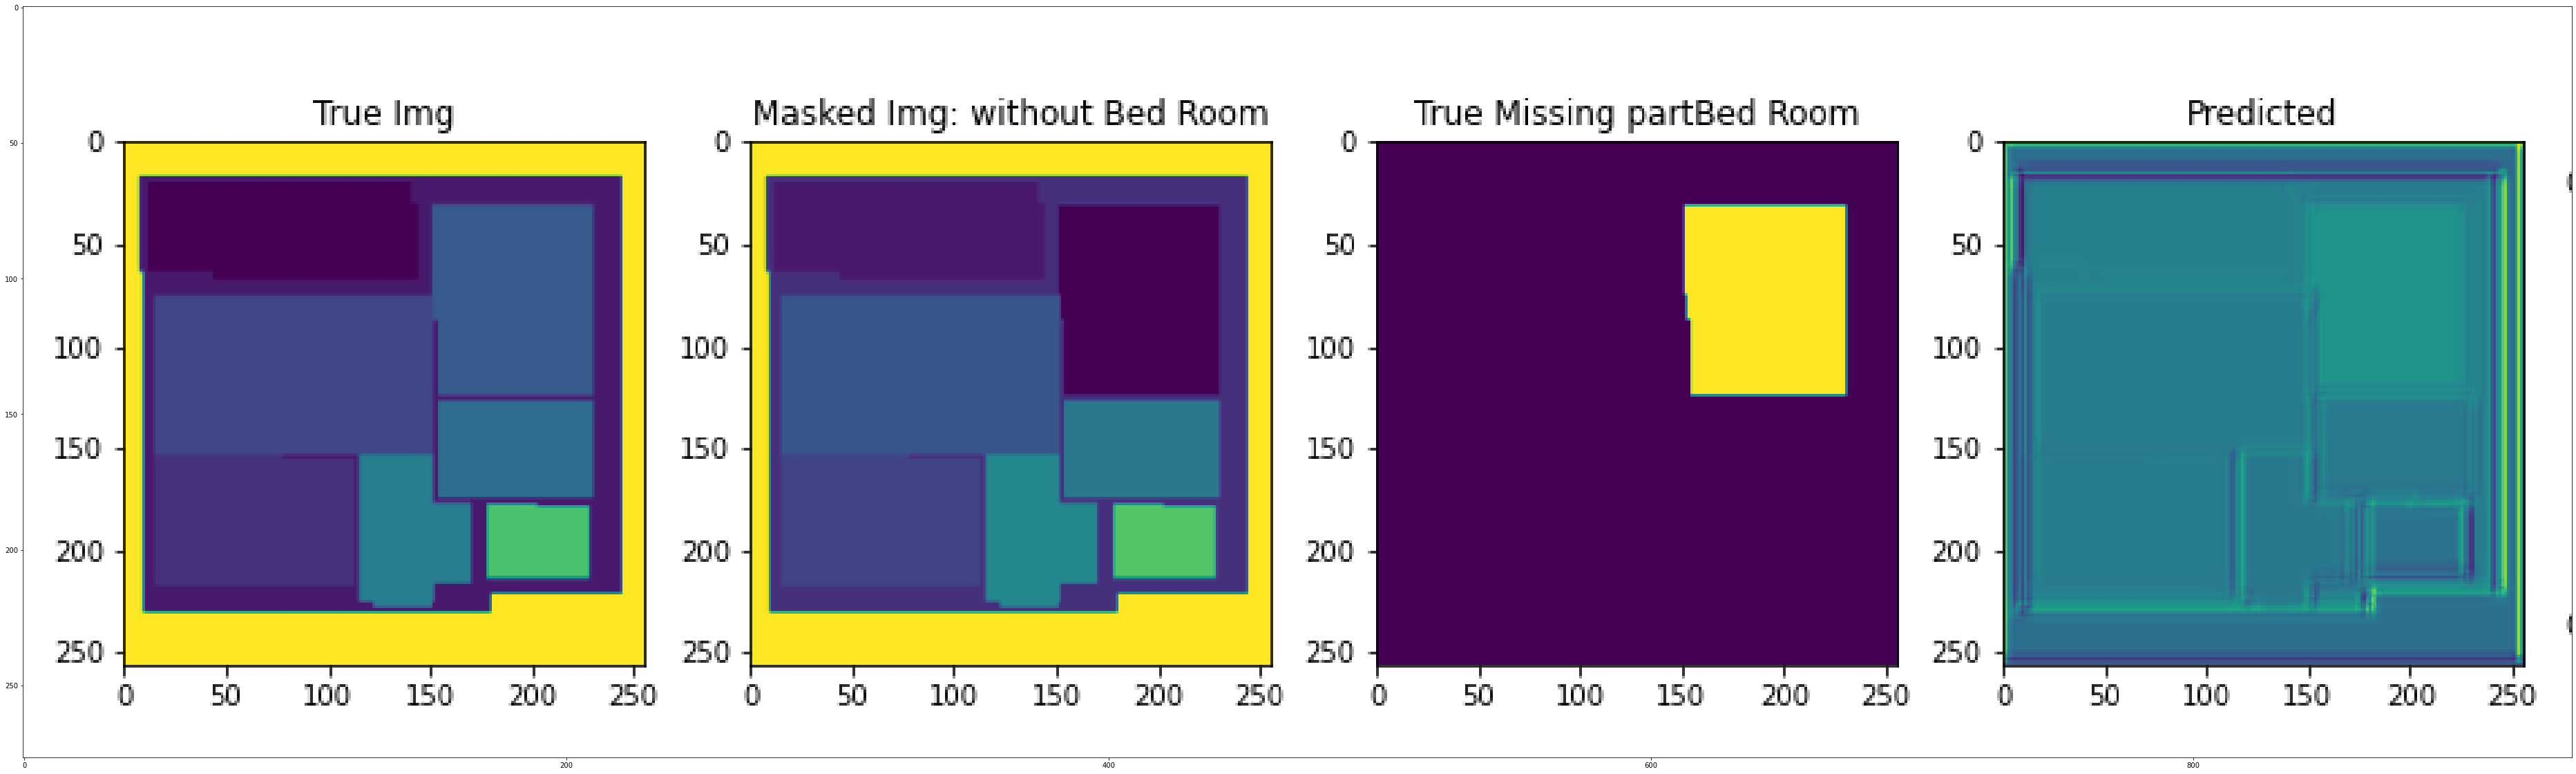

In [51]:
plt.figure(figsize = (100,20))
plt.imshow(image1)

The particular progresses epoch shows a failure to re-highlight the Missing Part in the Prediction img but rather dampens out the segmentation map. 

## Analysis of the limited performance：

Our Context-conditional Generative Adversarial Network doesn’t give us desired output as expected. Our missing part is scattered around the place and the auto-encoder fails to identify the correct missing parts. Given this result, we presented following reasons for that and hope to improve in further steps.


1) The design of the generator (autoencoder) needs to be thought through more carefully.

2)There are a lot of missing classification on the training data.  We realized an approximately 20% lack of room labels in our training process which might hamper the performance. 

3) The limitation of training epochs. Satisfying performance requires at least 5000 epochs on a 32 x32 dataset with 3 color channels. Our segmentation map has each dimension 256 x256x1 therefore, extremely hard to train sustainably on Hub.
The icon types are scattered and not regularly shaped. The referenced paper only takes a look on a predefined masking face ( only 1 rectangle) that is at least 75% smaller than the original image. Since the icon types and room types are not  necessarily rectangular, and tend to scatter around across different areas with varying sizes( some of them are too small and some of them are too big compared to the true image). It is very have to predict on every missing spot by simply doing contextual analysis on the masked segmentation map. In other words, we are kind of expecting the GAN to figure out not only the type but the location of the recommended room/icon type for each image. This problem is particularly troublesome in icons since the icon segmentation is dominated by backgrounds that do not incorporate any useful contextual information.

4).Relatively monotonous images. Generative adversarial networks have shown impressive performance on many diverse datasets. However, samples are most coherent when the set of images the network is trained on comes from a limited domain (eg. faces), which is just the case our dataset. We seek to train on one-hot-encoded floor plans without any further information or nuances between pixels.Most of them are just color blocks with integers. All images have only one channel and are relatively the same apart from the number of different types rooms, the location of rooms, different types of icons and the location of different icons. Even though there are 12 room classes and 11 icon classes, the difference between each other is slight, those horizontal lines, vertical lines and shapes can not be easily learned using Generative Adversarial Network compared with colorful and diverse image datasets used in those successful cases.

5)Finally, the complexity and scope of our goal. The typical task that context conditional GANs address is to determine if a part of an image is real or fake given the surrounding context. However, the relationship of different rooms and icons on a single floor plan is not so strong and close, not like a image of bird or a car. So, using surrounding context may not give a determined prediction of the missing part. In addition to that, we not only seek to recover the missing part, but also to mark the existed part as zero, which increased the difficulty of our task.

Overall while we attempt to tackle the room/icon recommendation problem using a context conditional GAN, we generated unsatisfactory results due to the training resource limitation,project time constraint  and the inherent lack of contextual continuity embeded in the input segmentation map.


## Future  Work:

For future revision, we would like to somehow combine the segmentation map with additional features possibly such as size, junctions , and transform this contextual encoder GAN into an INFOGan that not only incorporate a noise vector but also a vector of latent variables (in our case size, junctions ,etc) 
